## Notebook Outline
- 1. Competition Description
- 2. Variable Description
- 3. Simple EDA - waiting
- 4. LightGBM

## 1. Competiton Description

Battle Royale-style video games have taken the world by storm. 100 players are dropped onto an island empty-handed and must explore, scavenge, and eliminate other players until only one is left standing, all while the play zone continues to shrink.

PlayerUnknown's BattleGrounds (PUBG) has enjoyed massive popularity. With over 50 million copies sold, it's the fifth best selling game of all time, and has millions of active monthly players.

The team at PUBG has made official game data available for the public to explore and scavenge outside of "The Blue Circle." This competition is not an official or affiliated PUBG site - Kaggle collected data made possible through the PUBG Developer API.

You are given over 65,000 games' worth of anonymized player data, split into training and testing sets, and asked to predict final placement from final in-game stats and initial player ratings.

What's the best strategy to win in PUBG? Should you sit in one spot and hide your way into victory, or do you need to be the top shot?

In [1]:
import pandas as pd #Analysis 
import matplotlib.pyplot as plt #Visulization
import seaborn as sns #Visulization
import numpy as np #Analysis 
from scipy.stats import norm #Analysis 
from sklearn.preprocessing import StandardScaler #Analysis 
from scipy import stats #Analysis 
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

In [2]:
df_train = pd.read_csv('../input/train.csv')
df_test  = pd.read_csv('../input/test.csv')

In [3]:
df_train.shape, df_test.shape

((4357336, 26), (1867913, 25))

In [4]:
df_train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,maxPlace,numGroups,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,0,24,0,0,5,247.30,2,0,4,17,1050,2,1,65.32,29,28,1,591.3,0,0.0,0,0,782.40,4,1458,0.8571
1,1,440875,1,1,0,37.65,1,1,0,45,1072,1,1,13.55,26,23,0,0.0,0,0.0,0,0,119.60,3,1511,0.0400
2,2,878242,2,0,1,93.73,1,0,2,54,1404,0,0,0.00,28,28,1,0.0,0,0.0,0,0,3248.00,5,1583,0.7407
3,3,1319841,3,0,0,95.88,0,0,0,86,1069,0,0,0.00,97,94,0,0.0,0,0.0,0,0,21.49,1,1489,0.1146
4,4,1757883,4,0,1,0.00,0,0,1,58,1034,0,0,0.00,47,41,0,0.0,0,0.0,0,0,640.80,4,1475,0.5217


In [5]:
df_test.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,maxPlace,numGroups,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints
0,47734,1659463,47734,0,0,100.0,1,0,0,59,1000,0,0,0.000,50,45,0,0.0,0,0.0,1,0,421.50,7,1500
1,47735,1659508,47735,0,1,400.0,2,0,3,9,1200,4,2,15.420,48,47,1,0.0,0,0.0,0,0,655.80,4,1526
2,47736,1659555,47736,0,0,0.0,0,0,0,72,1216,0,0,0.000,29,28,0,0.0,0,0.0,0,0,74.58,1,1475
3,47737,1659621,47737,0,0,68.6,0,0,0,68,1177,0,0,0.000,97,92,0,0.0,0,0.0,0,0,167.20,2,1464
4,47738,1659675,47738,0,1,370.5,3,0,1,45,1013,1,1,5.968,27,26,0,0.0,0,0.0,0,0,146.70,3,1505


## 3. Variable Description
data description,

- matchId - Integer ID to identify match. There are no matches that are in both the training and testing set.
- groupId - Integer ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.

In [6]:
df_train[df_train['groupId']==2]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,maxPlace,numGroups,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
47734,68192,2,0,0,0,47.30,0,0,0,52,1158,0,0,0.0,29,28,0,0.0,0,0.00,0,0,1088.0,3,1485,0.6786
1565274,2236048,2,0,0,0,0.00,0,0,0,51,1255,0,0,0.0,29,28,0,0.0,0,16.11,0,0,2277.0,7,1546,0.6786
3723215,5318575,2,0,0,1,42.57,0,0,1,53,1000,0,0,0.0,29,28,0,0.0,0,0.00,0,0,336.8,4,1500,0.6786


In [7]:
len(df_train[df_train['matchId']==0]) 

99

Here we can see that  **Id** is different, but **groupId and matchId** are the same.

To illustrate this, a person A with an Id 0 and a person B with an ID 136382 are friends and have a team together (groupId). Then the same match is done, so you can assume that they entered the game with the same matchId.

To put it another way, Battlegrounds (PBUGs) have a total about 100 people per game. These 100 players have the same matchId. Among them, groupId are same as 24, so you can think that they are friends and joined the team and played together. (There are about 100 people, not necessarily 100 people.)

In [8]:
temp = df_train[df_train['matchId']==0]['groupId'].value_counts().sort_values(ascending=False)
trace = go.Bar(
    x = temp.index,
    y = (temp)
)
data = [trace]
layout = go.Layout(
    title = "GroupId of Match Id:0",
    xaxis=dict(
        title='groupId',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count of groupId of type of MatchId 0',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='schoolStateNames')

Note : You can see something strange in value counts. Four people are maximum team member and I do not know what it means more than four people.

MichaelApers metioned it.(https://www.kaggle.com/c/pubg-finish-placement-prediction/discussion/67742#400747)
I noticed in a kernel that @chocozzz was concerned about why there are sometimes more than 4 players with the same groupId. This can be from any of three causes:

1) The match is from a custom game/event (If there are more than 8 in a group, it is almost definitely this one)

2) The API mistakenly reported two groups as placing in the same place, and in creating groupId these groups were clumped as one larger group. This is also a contributor to the difference between "numGroups" and "maxPlace" (Teams leaving the game may also contribute).

3) There is a very rare bug in the game in which more than 4 people end up in one group (I am not sure if any of these games are included in this dataset).

I hope that this can help clarify group sizes.

### Data description detail
This game is simple. Pick up your weapons, walk around, kill enemies and survive until the end. So if you look at the variables, kill and ride will come out and if you stay alive you will win.

assists : The assists means that i don't kill enemy but help kill enemy. So when you look at the variable, there is also a kill. In other words, if I kill the enemy? kill +1. but if I did not kill the enemy but helped kill the enemy?assists + 1.

In [9]:
temp = df_train['assists'].value_counts().sort_values(ascending=False)

#print("Total number of states : ",len(temp))
trace = go.Bar(
    x = temp.index,
    y = (temp)
)
data = [trace]
layout = go.Layout(
    title = "",
    xaxis=dict(
        title='assists',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count of assists',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='schoolStateNames')

### Related variables with kills
kills : Number of enemy players killed.

In [10]:
temp = df_train['kills'].value_counts().sort_values(ascending=False)

trace = go.Bar(
    x = temp.index,
    y = (temp)
)
data = [trace]
layout = go.Layout(
    title = "",
    xaxis=dict(
        title='kills',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count of kills',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='schoolStateNames')

killStreaks : Max number of enemy players killed in a short amount of time.

In [11]:
temp = df_train['killStreaks'].value_counts().sort_values(ascending=False)

trace = go.Bar(
    x = temp.index,
    y = (temp)
)
data = [trace]
layout = go.Layout(
    title = "",
    xaxis=dict(
        title='killStreaks',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count of killStreaks',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='schoolStateNames')

- roadKills : Number of kills while in a vehicle.

In [12]:
temp = df_train['roadKills'].value_counts().sort_values(ascending=False)

trace = go.Bar(
    x = temp.index,
    y = (temp)
)
data = [trace]
layout = go.Layout(
    title = "",
    xaxis=dict(
        title='roadKills',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count of roadKills',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='schoolStateNames')

In [13]:
df_train['roadKills'].value_counts()

0     4347655
1        8697
2         754
3         124
4          62
5          21
6           8
7           5
10          3
11          2
9           2
42          1
13          1
8           1
Name: roadKills, dtype: int64

By the value count we can see that by killing someone with car is very difficult.

- teamKills : Number of times this player killed a teammate.

In [14]:
temp = df_train['teamKills'].value_counts().sort_values(ascending=False)

trace = go.Bar(
    x = temp.index,
    y = (temp),
)
data = [trace]
layout = go.Layout(
    title = "",
    xaxis=dict(
        title='teamKills',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count of teamKills',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='schoolStateNames')
0

0

In [15]:
df_train['teamKills'].value_counts()

0    4304426
1      46252
2       5834
3        728
4         86
6          6
5          4
Name: teamKills, dtype: int64

A team kill is when a playes in a team kills a player who is in the same team. The reasons behind killing team members could be.

- He's killing his team members for fun.
- The other member have a weapon that the player wants.
- The other member is not playing well.

There are only 4 members in a team so killing 4-6 members is not possible.

- longestKill : Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.

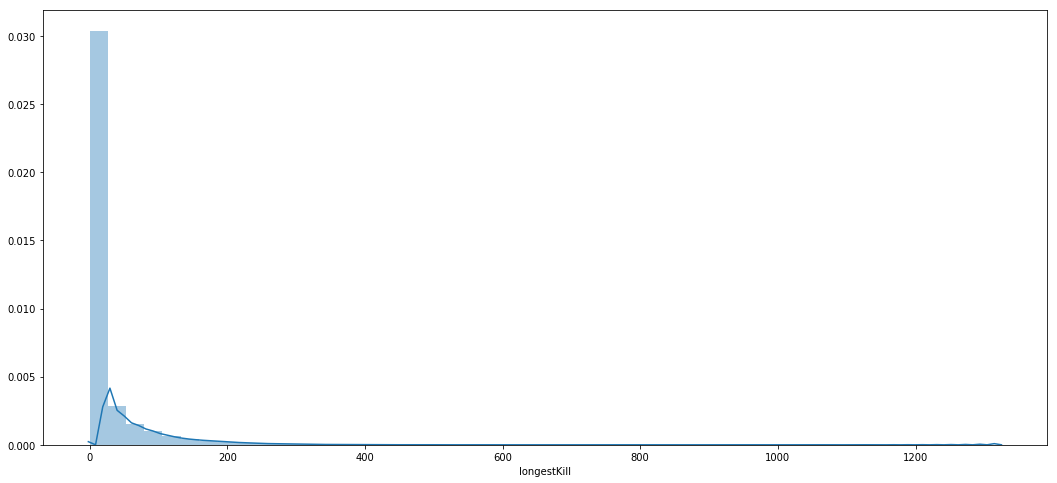

In [16]:
f, ax = plt.subplots(figsize=(18, 8))
sns.distplot(df_train['longestKill'])

There are many kinds of guns in the game. So, as you can see in the picture below, the number of times you pick up a gun is several times.

In [17]:
temp = df_train['weaponsAcquired'].value_counts().sort_values(ascending=False)

trace = go.Bar(
    x = temp.index,
    y = (temp),
)
data = [trace]
layout = go.Layout(
    title = "",
    xaxis=dict(
        title='weaponsAcquired',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count of weaponsAcquired',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='schoolStateNames')

Among the guns are special guns aimed at fighters at close range, and there are sniper guns that are specially designed to match enemies at long distances (The range is fixed for each gun ). So over a certain distance, all were shot by a sniper rifle.

## headshotKills - not knocked.
HeadshotKills means that a bullet hit his head and he died right away. it is important that he died right away.

DBNOs : Number of enemy players knocked.
DBNOs variable means Number of enemy players knocked. Knocked is not dead, but can not act. so if you are knocked, your colleagues can save you (revives variable) but if you died? you don't save... :(

In [18]:
temp = df_train['headshotKills'].value_counts().sort_values(ascending=False)

trace = go.Bar(
    x = temp.index,
    y = (temp),
)
data = [trace]
layout = go.Layout(
    title = "",
    xaxis=dict(
        title='headshotKills',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count of headshotKills',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='schoolStateNames')

In [19]:
df_train['headshotKills'].value_counts()

0     3586587
1      586339
2      131666
3       34981
4       10632
5        4019
6        1573
7         715
8         360
9         185
10         92
11         59
12         43
13         32
14         16
15         10
16          9
17          6
23          4
18          3
24          1
19          1
20          1
21          1
26          1
Name: headshotKills, dtype: int64

Here we can see that most of the players didn't even get 1 head shot kill. So we can say that getting a headshot kill is very difficult

In [20]:
temp = df_train['DBNOs'].value_counts().sort_values(ascending=False)

trace = go.Bar(
    x = temp.index,
    y = (temp),
)
data = [trace]
layout = go.Layout(
    title = "",
    xaxis=dict(
        title='DBNOs',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count of DBNOs',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='schoolStateNames')

what is difference boost vs heal?
Both of these variables are items that restore health. but the boosts immediately show the effect, and the heals show the effect slowly.

- boosts : Number of boost items used.
- heals : Number of healing items used.

In [21]:
temp = df_train['boosts'].value_counts().sort_values(ascending=False)

#print("Total number of states : ",len(temp))
trace = go.Bar(
    x = temp.index,
    y = (temp),
)
data = [trace]
layout = go.Layout(
    title = "",
    xaxis=dict(
        title='boosts',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count of boosts',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='schoolStateNames')

In [22]:
temp = df_train['heals'].value_counts().sort_values(ascending=False)

#print("Total number of states : ",len(temp))
trace = go.Bar(
    x = temp.index,
    y = (temp),
)
data = [trace]
layout = go.Layout(
    title = "",
    xaxis=dict(
        title='heals',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count of heals',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='schoolStateNames')

### Others
- damageDealt : Total damage dealt. Note: Self inflicted damage is subtracted. If it is not headshot, it does not die in one shot. So restores health by usingboosts or heals. damageDealt means how many bullets have ever been hit.

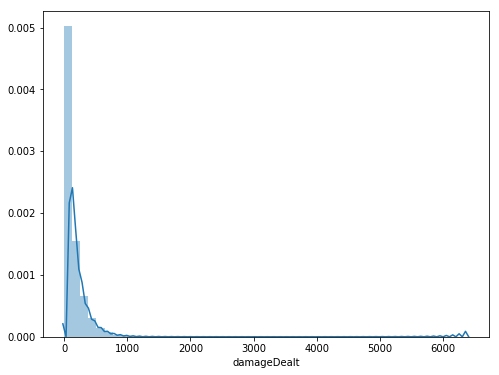

In [23]:
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(df_train['damageDealt'])

- revives : Number of times this player revived teammates. I said above, if you knock, your teammates can save you. If a team member is saved, the revives are +1.

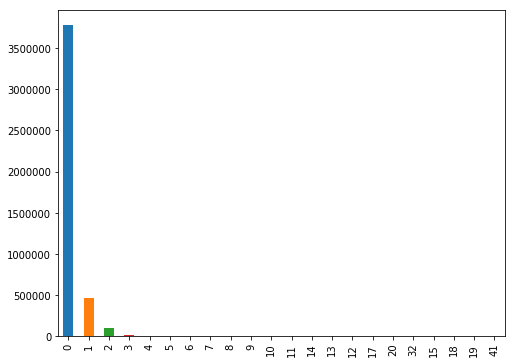

In [24]:
f, ax = plt.subplots(figsize=(8, 6))
df_train['revives'].value_counts().sort_values(ascending=False).plot.bar()

- walkDistance : Total distance traveled on foot measured in meters.

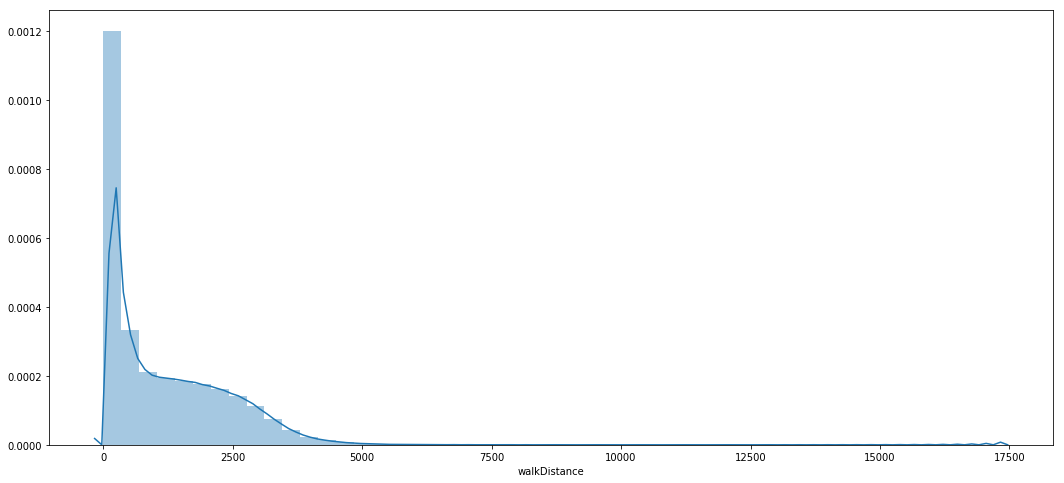

In [25]:
f, ax = plt.subplots(figsize=(18, 8))
sns.distplot(df_train['walkDistance'])

- rideDistance : Total distance traveled in vehicles measured in meters. The PUBG game is so wide that it is hard to walk around. So I ride around VEHICLE as shown in the picture below.

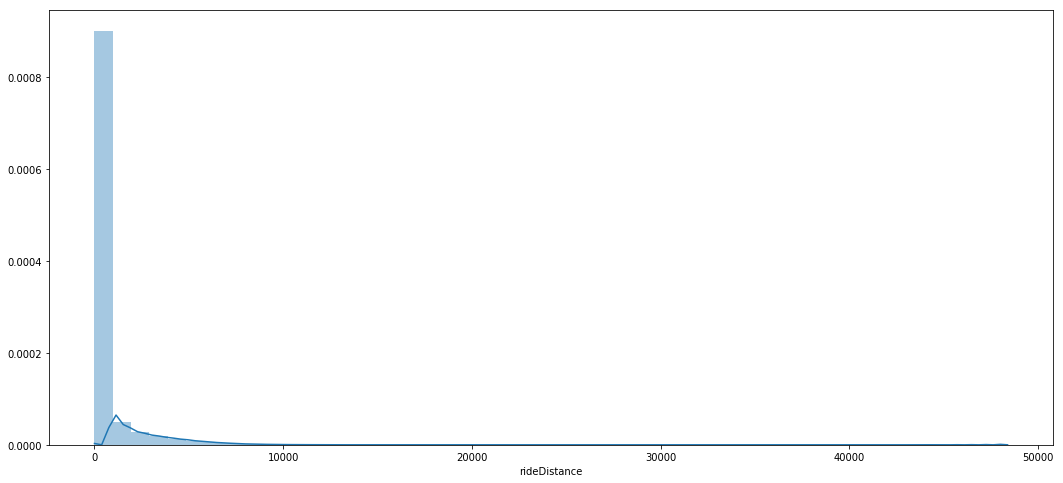

In [26]:
f, ax = plt.subplots(figsize=(18, 8))
sns.distplot(df_train['rideDistance'])

- swimDistance: Total distance traveled by swimming measured in meters. The map is wide, and there are some kind of river.

- vehicleDestroys: Number of vehicles destroyed.

In [27]:
temp = df_train['vehicleDestroys'].value_counts().sort_values(ascending=False)

trace = go.Bar(
    x = temp.index,
    y = (temp),
)
data = [trace]
layout = go.Layout(
    title = "",
    xaxis=dict(
        title='vehicleDestroys',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count of vehicleDestroys',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='schoolStateNames')

In [28]:
df_train['vehicleDestroys'].value_counts()

0    4335704
1      20898
2        682
3         48
5          2
4          2
Name: vehicleDestroys, dtype: int64

If you look at the above values, you will rarely destroy a vehicle. In fact, it is very natural. It is difficult to destroy the car. And there is no profit by destroying the car. Even so, the destruction of a car can be thought of in the following sense.

- The enemy was in the car and shot the car.
- The enemy hid the car in cover and shot the car.
- He broke a car with no meaning.

The third reason is very important. When you play games, you can meet a lot of strange people.

- weaponsAcquired : Number of weapons picked up. This game is a using gun , but it does not give a gun from the beginning. So you have to go around the map and look for weapons. In the process, you can also have heals, boosts and vehicles.

In [29]:
temp = df_train['weaponsAcquired'].value_counts().sort_values(ascending=False)

trace = go.Bar(
    x = temp.index,
    y = (temp),
)
data = [trace]
layout = go.Layout(
    title = "",
    xaxis=dict(
        title='weaponsAcquired',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count of weaponsAcquired',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='schoolStateNames')

There are many kinds of guns in the game. So, as you can see in the picture above, the number of times you pick up a gun is several times. but the big number like 76? does not mean the new gun acquired 76. just picked up the gun, dropped it and repeated it. (The reason behind this is almost every gun have 30 bullets in the gun, so to get the bullets the player could pick up the gun again and again but this 76 number is still strange. )

## 5. LightGBM

In [30]:
import os
import time
import gc
import warnings
warnings.filterwarnings("ignore")
# data manipulation
import json
from pandas.io.json import json_normalize
import numpy as np
import pandas as pd
# plot
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
# model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb

In [31]:
train_idx = df_train.Id
test_idx = df_test.Id
df_train["winPlacePerc"] = df_train["winPlacePerc"].astype('float')
train_y = df_train["winPlacePerc"]
train_target = df_train.groupby("Id")["winPlacePerc"].mean()

y_train = df_train["winPlacePerc"]
x_train = df_train.drop(["winPlacePerc"], axis=1)
x_test = df_test.copy()

In [ ]:
folds = KFold(n_splits=5,random_state=6)
oof_preds = np.zeros(x_train.shape[0])
sub_preds = np.zeros(x_test.shape[0])

start = time.time()
valid_score = 0
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(x_train, y_train)):
    trn_x, trn_y = x_train.iloc[trn_idx], y_train[trn_idx]
    val_x, val_y = x_train.iloc[val_idx], y_train[val_idx]    
    
    train_data = lgb.Dataset(data=trn_x, label=trn_y)
    valid_data = lgb.Dataset(data=val_x, label=val_y)
    
    params = {"objective" : "regression", "metric" : "mae", 'n_estimators':10000, 'early_stopping_rounds':100,
              "num_leaves" : 30, "learning_rate" : 0.1, "bagging_fraction" : 0.9,
               "bagging_seed" : 0}
    
    lgb_model = lgb.train(params, train_data, valid_sets=[train_data, valid_data], verbose_eval=1000) 
    
    oof_preds[val_idx] = lgb_model.predict(val_x, num_iteration=lgb_model.best_iteration)
    oof_preds[oof_preds>1] = 1
    oof_preds[oof_preds<0] = 0
    sub_pred = lgb_model.predict(x_test, num_iteration=lgb_model.best_iteration) / folds.n_splits
    sub_pred[sub_pred>1] = 1 # should be greater or equal to 1
    sub_pred[sub_pred<0] = 0 
    sub_preds += sub_pred
    print('Fold %2d RMSE : %.6f' % (n_fold + 1, mean_absolute_error(val_y, oof_preds[val_idx])))
    valid_score += mean_absolute_error(val_y, oof_preds[val_idx])

In [ ]:
test_pred = pd.DataFrame({"Id":test_idx})
test_pred["winPlacePerc"] = sub_preds
test_pred.columns = ["Id", "winPlacePerc"]
test_pred.to_csv("lgb_base_model.csv", index=False) # submission